### Fundamentals and Emerging Trends in Graph Learning (Prof. Won-Yong Shin)

#### Assignment #5
- Written by Yong-Min Shin (jordan3414@yonsei.ac.kr), issued on: 5th Oct.
- Assignment due: 10th Oct. 23:59. Please send your file to Prof. Won-Yong Shin (wy.shin@yonsei.ac.kr).

##### Introduction

In this week, we have read GraphSAGE [1], also one of the most widely used architecture alongside GCN [5]. From an architectural standpoint, there are two key contributions from [1]. The first contribution is the introduction of various aggregation functions, including mean, pooling, and even LSTMs (though this is rarely used due to its effect in the model size). The second contribution is the idea of batch training for GNNs and *node sampling*. Sampling in GNNs was first introduced in GraphSAGE (although a concurrent work, FastGCN [2], also proposed an another sampling method), and its objective is to reduce model's complexity while (at least) preserving the performance.

This assignment is dedicated on the latter contribution of GraphSAGE. In Figure 2 in [1], the authors compare (a) time consumed for various aggregation methods at training vs. inference time using a fixed sized batch (b) performance & runtime tradeoff for different number of neighbor node sampling. Such analysis regarding the complexity highlights key aspects of GraphSAGE, but perhaps the analysis is not complete.

As mentioned, these design choices are made with model efficiency in mind. Model efficiency is a crucial aspect, especially in the context of real-word model deployment, and therefore it is common for papers in machine learning to perform some sort of complexity analysis. Recently, the complexity comparison for deep learning models itself was called into question in [4]. The paper suggests to avoid performaing complexity analysis using one single metric, and should provide a comprehensive analysis using multiple measures of complexity. The main metrics discussed in [4] is as follows:

- FLOPs: Floating point operations (Don't be confused with FLOPS, which stands for floating point operations per second)
- Number of trainable parameters
- Multiple measures of speed
  - Throughput: Number of inputs processed per second
  - Latency: Forward-pass time for either a given example or a batch of examples
  - Wall-clock time (runtime): Total training time up to convergence
  - Pipeline bubble: Idle device time for each batch (not of interest here)
  - MAC (Memory access cost): Number of memory access

Additionally,
- Memory consumption (discussed in the appendix).

Taking [4] by heart, the goal of this assignment is to perform a comprehensive analysis for GraphSAGE [1] using FLOPs, latency and memory consumption. Due to the characteristics of this assignment, it is highly advised to use pytorch geometric.

```python
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import SGConv
from torch_geometric.nn import GCNConv
# Define your model
```

##### Task

We will perform various complexity measures on GraphSAGE using **profilers**. As described in [5], if the number of nodes in a batch is greater than one, we can expect some increase in efficiency in latency as intermediate representations of some nodes will get reused. For example, lets say in a GraphSAGE model with 3 layers, we have a batch of 2 nodes. It is not difficult to imaging nodes that are 1) not in the batch 2) but is within the 3-hop neighborhood of both nodes, and these nodes will get reused. As the size of the batch grows in size, we can expect such phenomenon will happen more often. Expecting such phenomenon, by using **FLOPs (MACs are also acceptable)**, **latency** and **memory consumption**, observe what happens during the feed forward process when we vary the size of the batch & number of nodes sampled per layer. Please plot your results and discussions in a comprehensive fashion. 

[Additional guidelines]
- Use the Cora dataset.
- Explicitly use some form of neighbor sampling (Appendix A in [1]), rather than selecting the target nodes after convolving over the whole graph.

#### Example solution

##### Making a custom profiler

Some parts of deepspeed we need, some parts we do not. We can make a custom profile class by grabbing the source code from deepspeed to fit our needs. Custom_Profiler is a newly defined class with slight modifications from deepspeed.profiling.flops_profiler.profiler. This will take care in providing measurements for FLOPs, MACs, Latency.

In [9]:
from deepspeed.profiling.flops_profiler.profiler import *

class Custom_Profiler:
    def __init__(self, model):
        assert isinstance(model, nn.Module)
        self.model = model.eval()

    def get_model_profile(self, batch):
        model = self.model
        prof = FlopsProfiler(model)
        model.eval()


        prof.start_profile()

        _ = model(batch)

        flops = prof.get_total_flops()
        macs = prof.get_total_macs()
        params = prof.get_total_params()
        latency = prof.get_total_duration() # new!

        prof.end_profile()
        prof.reset_profile()

        return flops, macs, params, latency

profile_SAGE = Custom_Profiler(model)
batch = next(iter(train_loader)).to(device)
flops, macs, params, latency = profile_SAGE.get_model_profile(batch)
print(f"FLOPs: {flops}, MACs: {macs}, ParamsL {params}, Latency: {latency}") # It seems to work ok

FLOPs: 1602420736, MACs: 801210368, ParamsL 401671, Latency: 0.564551830291748


##### 1. Batch-wise analysis (FLOPs, MACs, Latency)

In [10]:
from deepspeed.profiling.flops_profiler import get_model_profile
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def get_FLOPs_MACs_Latency(
    model, data, custom_profiler: Custom_Profiler, batch_size: int = 1, node_sample: int = 10, device: str = "cuda"
):
    train_loader = LinkNeighborLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_neighbors=[node_sample] * 3,
    )
    batch = next(iter(train_loader)).to(device) # just use one batch
    flops, macs, _, latency = custom_profiler.get_model_profile(batch)

    return flops, macs, latency

In [13]:
def plot_with_std(data: np.array, title: str, xlabels:str, ylabels:str, xlabelnames:list=None):
    result_avg = np.average(data, axis=0)
    result_std = np.std(data, axis=0)
    upper = [(result_avg[i] + result_std[i]) for i in range(len(result_avg))]
    lower = [(result_avg[i] - result_std[i]) for i in range(len(result_avg))]
    plt.figure(figsize=(8,6), dpi = 80)
    plt.plot(result_avg, 'bo-')
    plt.fill_between(range(len(result_avg)), upper, lower, alpha=.4)
    plt.xticks(ticks=list(range(len(xlabelnames))),labels=xlabelnames)
    plt.xlabel(xlabels)
    plt.title(title)
    plt.ylabel(ylabels)
    plt.show()

In [12]:
# Define model
model = GraphSAGE(
    in_channels=data.num_features, hidden_channels=128, output_channels=num_class
).to(device)
# Prepare profiler
profile_SAGE = Custom_Profiler(model)

# Define experiment settings
num_trials = 20
batch_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]
flops_log = np.zeros((num_trials, len(batch_list)))
macs_log = np.zeros((num_trials, len(batch_list)))
latency_log = np.zeros((num_trials, len(batch_list)))

for trials in range(num_trials):
    for ind, batch_size in enumerate(batch_list):
        flops, macs, latency = get_FLOPs_MACs_Latency(
            model=model,
            data=data,
            custom_profiler=profile_SAGE,
            batch_size=batch_size,
            node_sample=-1,
        )
        flops_log[trials][ind] = flops
        macs_log[trials][ind] = macs
        latency_log[trials][ind] = latency


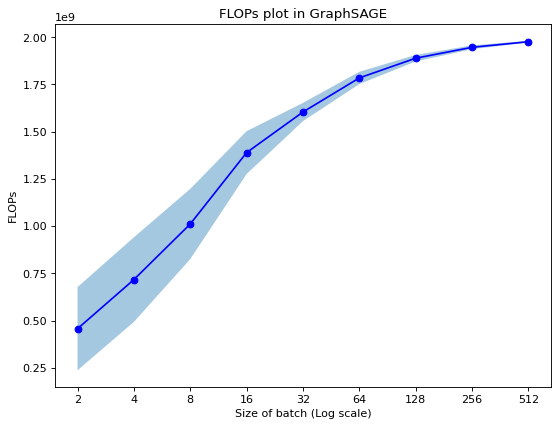

In [14]:
plot_with_std(
    data=flops_log,
    title="FLOPs plot in GraphSAGE",
    xlabels="Size of batch (Log scale)",
    ylabels = 'FLOPs',
    xlabelnames=[str(num) for num in batch_list],
)


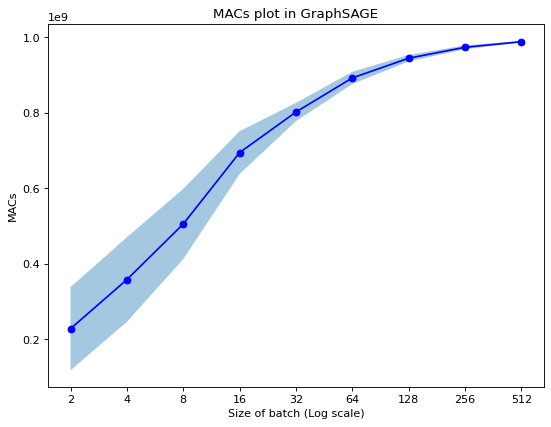

In [15]:
plot_with_std(
    data=macs_log,
    title="MACs plot in GraphSAGE",
    xlabels="Size of batch (Log scale)",
    ylabels = 'MACs',
    xlabelnames=[str(num) for num in batch_list],
)


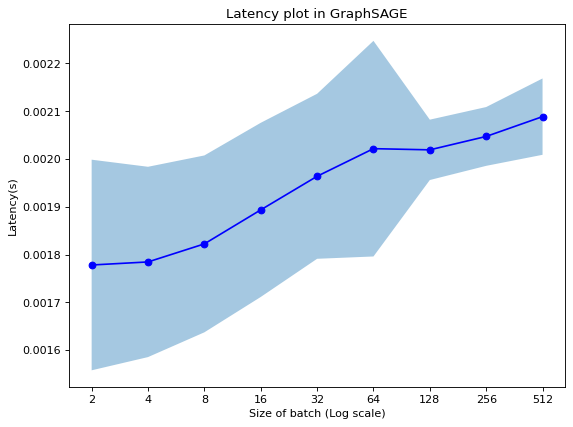

In [16]:
plot_with_std(
    data=latency_log,
    title="Latency plot in GraphSAGE",
    xlabels="Size of batch (Log scale)",
    ylabels = 'Latency(s)',
    xlabelnames=[str(num) for num in batch_list],
)


##### 2. Batch-wise analysis (Memory)

In [23]:
from torch_geometric.profile import profileit # profileit will take care of memory tracking
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Prepare batch
batch = next(iter(train_loader))

# Just need one forward pass
@profileit()
def simple_forward_pass_without_gradients(model, batch, device='cuda'):
    model.to(device)
    model.eval()
    batch.to(device)
    with torch.no_grad():
        model(batch)

def get_memory_usage(
    model, data, batch_size: int = 1, node_sample: int = 10, device: str = "cuda"
):
    train_loader = LinkNeighborLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_neighbors=[node_sample] * 3,
    )
    batch = next(iter(train_loader)).to(device)
    _, stats = simple_forward_pass_without_gradients(model, batch)
    
    return stats.nvidia_smi_used_cuda

In [18]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Define model
model = GraphSAGE(
    in_channels=data.num_features, hidden_channels=128, output_channels=num_class
).to(device)

# Define experiment settings
num_trials = 20
batch_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]
memory_log = np.zeros((num_trials, len(batch_list)))

for trials in range(num_trials):
    for ind, batch_size in enumerate(batch_list):
        memory = get_memory_usage(
            model=model,
            data=data,
            batch_size=batch_size,
            node_sample=-1,
        )
        memory_log[trials][ind] = memory


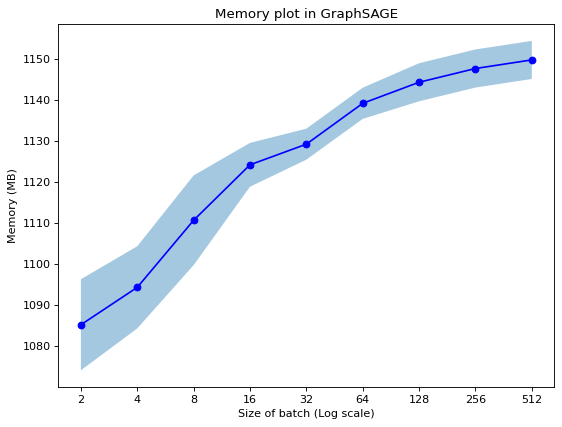

In [20]:
plot_with_std(
    data=memory_log,
    title="Memory plot in GraphSAGE",
    xlabels="Size of batch (Log scale)",
    ylabels = 'Memory (MB)',
    xlabelnames=[str(num) for num in batch_list],
)


##### 3. Node sample ratio analysis (FLOPS, MACs, latency, memory)

In [36]:
# Define model
model = GraphSAGE(
    in_channels=data.num_features, hidden_channels=128, output_channels=num_class
).to(device)
# Prepare custom profiler
profile_SAGE = Custom_Profiler(model)

# Set experiment settings
batch_size = 16
num_trials = 20

node_sample_list = [1, 2, 4, 8, 16, 32, 64, -1]
flops_log = np.zeros((num_trials, len(node_sample_list)))
macs_log = np.zeros((num_trials, len(node_sample_list)))
latency_log = np.zeros((num_trials, len(node_sample_list)))

for trials in range(num_trials):
    for ind, node_sample in enumerate(node_sample_list):
        flops, macs, latency = get_FLOPs_MACs_Latency(
            model=model,
            data=data,
            custom_profiler=profile_SAGE,
            batch_size=batch_size,
            node_sample=node_sample,
        )
        flops_log[trials][ind] = flops
        macs_log[trials][ind] = macs
        latency_log[trials][ind] = latency


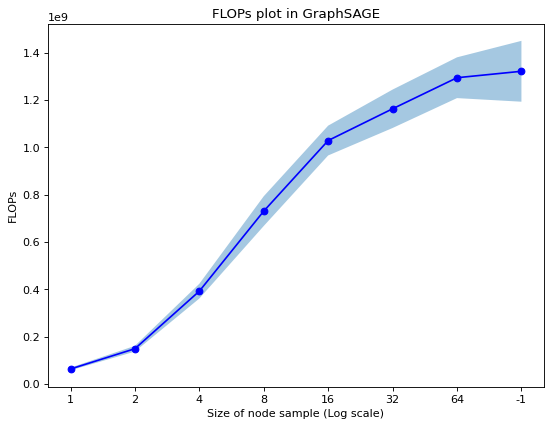

In [37]:
plot_with_std(
    data=flops_log,
    title="FLOPs plot in GraphSAGE",
    xlabels="Size of node sample (Log scale)",
    ylabels = 'FLOPs',
    xlabelnames=[str(num) for num in node_sample_list],
)

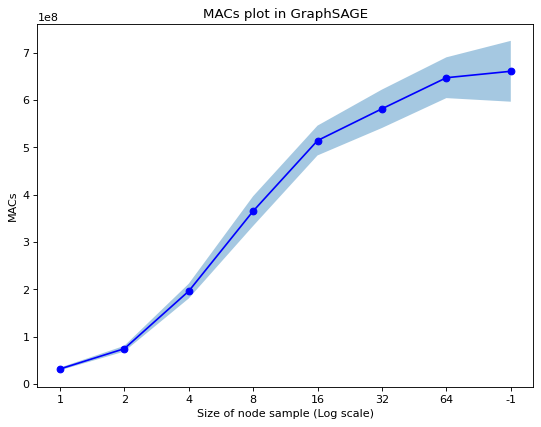

In [38]:
plot_with_std(
    data=macs_log,
    title="MACs plot in GraphSAGE",
    xlabels="Size of node sample (Log scale)",
    ylabels = 'MACs',
    xlabelnames=[str(num) for num in node_sample_list],
)


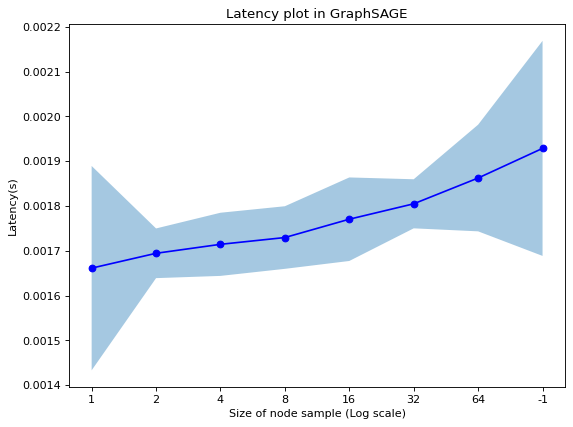

In [39]:
plot_with_std(
    data=latency_log,
    title="Latency plot in GraphSAGE",
    xlabels="Size of node sample (Log scale)",
    ylabels = 'Latency(s)',
    xlabelnames=[str(num) for num in node_sample_list],
)


In [42]:
# Prepare model
model = GraphSAGE(
    in_channels=data.num_features, hidden_channels=128, output_channels=num_class
).to(device)

# Set experiment settings
batch_size = 16
num_trials = 20

node_sample_list = [1, 2, 4, 8, 16, 32]
memory_log = np.zeros((num_trials, len(node_sample_list)))

for trials in range(num_trials):
    for ind, node_sample in enumerate(node_sample_list):
        memory = get_memory_usage(
            model=model,
            data=data,
            batch_size=batch_size,
            node_sample=node_sample,
        )
        memory_log[trials][ind] = memory

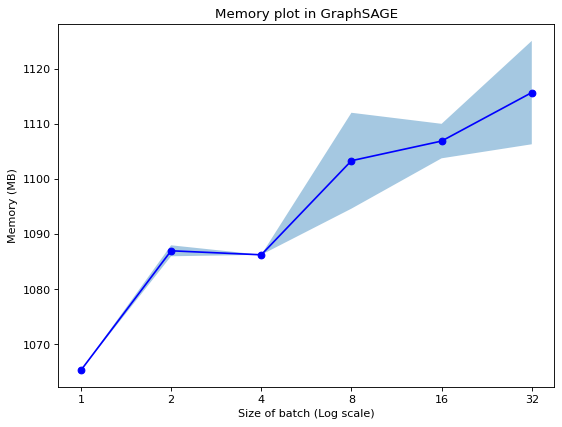

In [43]:
plot_with_std(
    data=memory_log,
    title="Memory plot in GraphSAGE",
    xlabels="Size of batch (Log scale)",
    ylabels = 'Memory (MB)',
    xlabelnames=[str(num) for num in node_sample_list],
)


[Implementation guidelines]
- The experiment is expected to *mainly* use the following libraries (but not strictly limited to): Pytorch, Pytorch Geometric (NetworkX and Matplotlib will be helpful)
- Pytorch (https://pytorch.org/) is a deep learning framework based on python, and widely used especially for scientific research.
- Pytorch Geometric (https://pytorch-geometric.readthedocs.io/en/latest/) is an extension library based on Pytorch, focusing on deep learning on graph data. We expect everyone to learn how to use this library over the course of the semester.
- It is encouraged to browse the internet for advise on code. You will need it especially if you have no experience in either Pytorch of Pytorch Geometric. The official documentation is always an excellent reference if you are lost.
- Pytorch: Installation (https://pytorch.org/get-started/locally/), tutorials (https://pytorch.org/tutorials/), documentation (https://pytorch.org/docs/stable/index.html).
- Pytorch Geometric: Installation (https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html), examples (https://github.com/pyg-team/pytorch_geometric/tree/master/examples).
- **DO NOT COPY PASTE EXISTING SOLUTIONS FOR YOUR ASSIGNMENT.** The references are for references uses only, and try to code for yourself as much as you can. You can get penalties if large portions of your code turns out to be straight copies from other open sources.
- The jupyter notebook is considered itself a self-contained report of your work. Try to show all your work in one notebook file unless specifically required not to do so.
- We do not limit what profiler that you use: *fvcore, ptflops, pthflops, pytorch-OpCounter, torch.profiler, torch.autograd.profiler, deepspeed, PyProf, torch_geometric.profile*, etc. *Disclaimer: Compatability of some libraries in GNN models are not guaranteed.

Additional info: *fvcore* is not compatable with PyG. *pytorch-OpCounter* fails to count. *torch.autograd.profiler* is now deprecated in pytorch. *PyProf* is no longer maintained as of Apr. 2021.

\
\
[References]

[1] Hamilton et al., "Inductive representation learning on large graphs", NeurIPS 2017 \
[2] Chen et al., "FastGCN: Fast learning with graph convolutional networks via importance sampling", ICLR 2018 \
[3] Wu et al., "Simplifying graph convolutional networks", ICML 2019 \
[4] Dehghani et al., "The efficiency misnomer", ICLR 2022 \
[5] Chiang et al., "Cluster-GCN: An efficient algorithm for training deep and large graph convolutional networks, KDD 2019